# Training Demo with 70/30 Split

This notebook demonstrates how to load data, perform a 70/30 train/test split, train a model using the project's architecture, and visualize the training curve.

In [1]:
import sys
import os
from pathlib import Path

# Add src to path to allow imports from the project
current_dir = Path(os.getcwd())
project_root = current_dir.parent
src_path = project_root / "src"
if str(src_path) not in sys.path:
    sys.path.append(str(src_path))

import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset

# Import model builder from the project
from models.mlp import build_mlp

## 1. Data Generation
We generate a synthetic classification dataset to demonstrate the pipeline.

In [2]:
# Generate synthetic data
# 1000 samples, 40 features, 3 classes
X, y = make_classification(
    n_samples=1000,
    n_features=40,
    n_informative=20,
    n_classes=3,
    random_state=42
)

print(f"Total samples: {X.shape[0]}")
print(f"Features: {X.shape[1]}")
print(f"Classes: {len(np.unique(y))}")

Total samples: 1000
Features: 40
Classes: 3


## 2. 70/30 Train/Test Split
Here we explicitly split the data into 70% training and 30% testing sets.

In [3]:
# 70/30 Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

print(f"Training set size: {X_train.shape[0]} ({X_train.shape[0]/X.shape[0]:.0%})")
print(f"Test set size: {X_test.shape[0]} ({X_test.shape[0]/X.shape[0]:.0%})")

# Convert to PyTorch tensors
train_dataset = TensorDataset(
    torch.FloatTensor(X_train), torch.LongTensor(y_train)
)
test_dataset = TensorDataset(
    torch.FloatTensor(X_test), torch.LongTensor(y_test)
)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)

Training set size: 700 (70%)
Test set size: 300 (30%)


## 3. Model Initialization
We use the `build_mlp` function from `src.models.mlp` to create a model compatible with the project structure.

In [4]:
# Configuration for the model
config = {
    "mlp_small": {
        "hidden_sizes": [128, 64],
        "dropout": 0.2
    },
    "mlp_activation": "relu"
}

input_dim = X.shape[1]
num_classes = 3

# Build model using project's utility
model = build_mlp("mlp_small", input_dim, num_classes, config)
print(model)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

MLPClassifier(
  (backbone): Sequential(
    (0): Linear(in_features=40, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=128, out_features=64, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.2, inplace=False)
  )
  (classifier): Linear(in_features=64, out_features=3, bias=True)
)


## 4. Training Loop
We train the model for a fixed number of epochs and track the loss and accuracy.

In [5]:
num_epochs = 50
train_losses = []
test_accuracies = []

for epoch in range(num_epochs):
    model.train()
    batch_losses = []
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        batch_losses.append(loss.item())
    
    avg_loss = np.mean(batch_losses)
    train_losses.append(avg_loss)
    
    # Evaluation
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, targets in test_loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += targets.size(0)
            correct += (predicted == targets).sum().item()
    
    accuracy = 100 * correct / total
    test_accuracies.append(accuracy)
    
    if (epoch + 1) % 5 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}, Accuracy: {accuracy:.2f}%')

Epoch [5/50], Loss: 0.5284, Accuracy: 78.67%
Epoch [10/50], Loss: 0.2944, Accuracy: 80.67%
Epoch [15/50], Loss: 0.2055, Accuracy: 83.33%
Epoch [20/50], Loss: 0.1308, Accuracy: 83.33%
Epoch [25/50], Loss: 0.0905, Accuracy: 83.00%
Epoch [30/50], Loss: 0.0737, Accuracy: 83.33%
Epoch [35/50], Loss: 0.0619, Accuracy: 83.67%
Epoch [40/50], Loss: 0.0332, Accuracy: 83.67%
Epoch [45/50], Loss: 0.0330, Accuracy: 84.33%
Epoch [50/50], Loss: 0.0355, Accuracy: 85.00%


## 5. Training Curve
Visualizing the training loss and test accuracy over epochs.

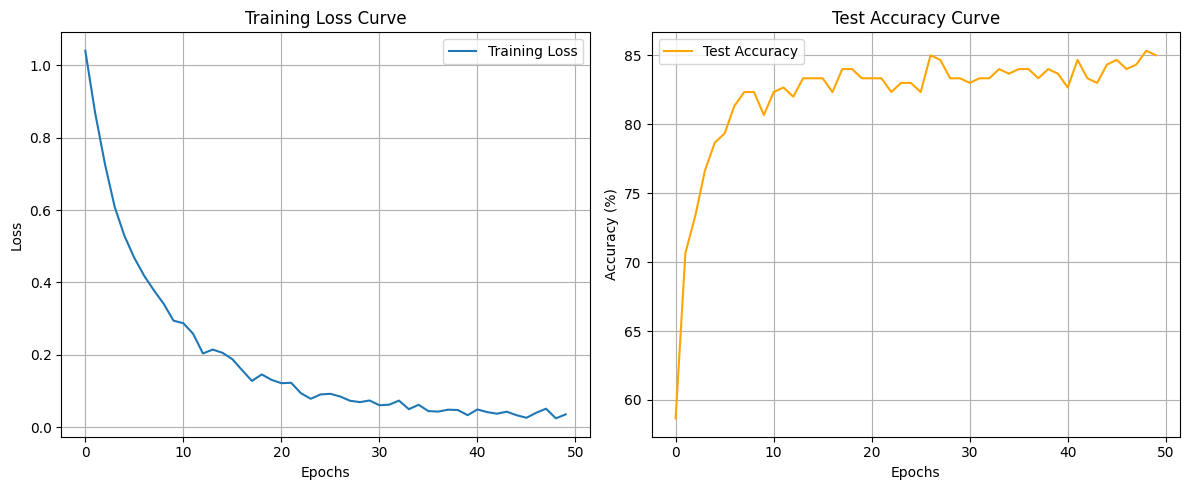

In [6]:
plt.figure(figsize=(12, 5))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.title('Training Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(test_accuracies, label='Test Accuracy', color='orange')
plt.title('Test Accuracy Curve')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()